In [1]:
# GPU scaling lidDrivenCavity
# comparison OF + DIC vs GKO and var. preconditioner
import matplotlib.pyplot as plt
import numpy as np
from import_benchmark_data import import_results
from helpers import idx_query, idx_keep_only, compute_speedup

plt.rcParams.update({'font.size': 18})

No Salvia installation found
Owls Version: 0.10.0-26-g31283c0
Warning no matplotlib support


In [2]:
def line_plot(df, x, columns, facet, properties, 
              fig, axes, kind="line", x_label=None, 
              facet_is_legend=False):
    lines = list(set(df.index.get_level_values(facet)))
    lines.sort()
    default_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    for i, q in enumerate(columns):
        for j,line in enumerate(lines):
            sel = df[df.index.get_level_values(facet) == line]
            sel = idx_keep_only(sel,  keep=[x])
            ax = axes[i]
            legends = properties.get("legends")
            legend = line  if facet_is_legend else False
            f = sel.sort_index().plot(
                legend=True,
                label=legend,
                lw=3,
                ms=10,
                kind=kind,
                ax=ax,
                linestyle=properties.get("linestyle", lambda x: "-")(line),
                marker=properties["marker"](line),
                color=properties.get("color", lambda x: default_colors[j])(line),
            )
            if x_label:
                ax.set_xlabel(x_label[i])
            if legends:
                plt.legend(legends)

In [3]:
def calc_nodes(df, sel, masks):
    df["nodes"] = df.index.get_level_values('mpi_ranks')
    for sel_value, value in masks:
        mask = df.index.get_level_values(sel) == sel_value
        df.loc[mask,"nodes"] = df.loc[mask, "nodes"]/value
    df = df.set_index("nodes", append=True)
    return df

## Number Iterations Scotch vs Simple OF

../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
../../results/14aed08a/lidDrivenCavity/simple/Logs
../../results/14aed08a/lidDrivenCavity/ simple


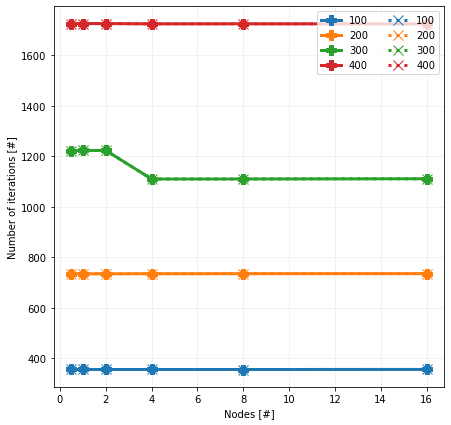

In [6]:
columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                        len(columns),
                        figsize=(7 * len(columns), 7),
                        sharex=False,
                        sharey=False,
                        gridspec_kw={'wspace': 0.5},
                        subplot_kw={'frameon': True})
axes.set_ylabel("Number of iterations [#]")

axes = [axes]

for revision, marker, linestyle, cpu, case  in [("f66ef73d","P","-", 64, "simple"), ("14aed08a","x", ":", 64, "simple")]:
    path = "../../results/{}/lidDrivenCavity/".format(revision)
    df = import_results(
        path=path,
        case=case,        
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka"
        },
        transform_resolution=False
        )["raw"]


    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True)
            ])

    df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
    df = calc_nodes(df, "executor_p", [("DefaultOF", cpu), ("CUDA",4)])

    data = idx_query(df, [
            ("executor_p", "DefaultOF"),
            ("nodes", 64, False),
            ("resolution", 500, False),
            ("nodes", 32, False),
        ]).sort_index()

    line_plot(data["number_iterations_p"], 
            x="nodes", 
            columns=columns, 
            facet="resolution",
            #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
            fig=fig,
            axes=axes,
            facet_is_legend=True,
            properties={
            "linestyle": lambda x: linestyle,
            "marker": lambda x: marker,
            "title": lambda x: ["Linear Solve P"][x]
        })

for ax in axes:
    ax.grid(True, axis='x', which="both", alpha=0.2)
    ax.grid(True, axis='y', which="both", alpha=0.2)
    ax.grid(True, axis="y", which="minor", alpha=0.2)
    ax.set_xlabel("Nodes [#]")
    
plt.legend(ncol=2)#, loc="top center")
print(path, case)
plt.savefig(path + case +  "/number_iterations_scotch_vs_simple_dd.png", bbox_inches='tight')

../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
../../results/14aed08a/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


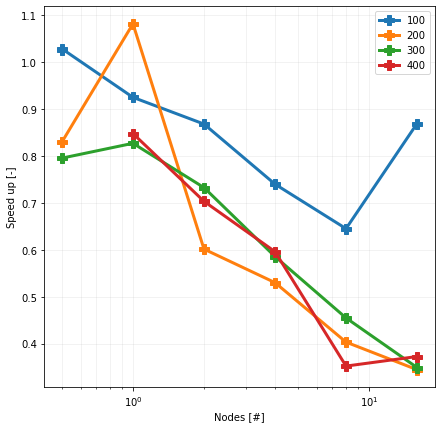

In [12]:
import pandas as pd
columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                        len(columns),
                        figsize=(7 * len(columns), 7),
                        sharex=False,
                        sharey=False,
                        gridspec_kw={'wspace': 0.5},
                        subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")

axes = [axes]
dfs = {}

for revision, marker, linestyle, cpu, case  in [("f66ef73d","P","-", 64, "simple"), ("14aed08a","x", ":", 64, "simple")]:
    path = "../../results/{}/lidDrivenCavity/".format(revision)
    df_tmp = import_results(
        path=path,
        case=case,        
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka"
        },
        transform_resolution=False
        )["raw"]
    df_tmp["revision"] = revision
    df_tmp = df_tmp.set_index("revision", append=True)
    dfs[revision] = df_tmp

    
df_c = pd.concat([dfs["f66ef73d"], dfs["14aed08a"]])
df = df_c.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)


df_gko = idx_query(df, [
        ("executor_p", "CUDA"),
        ("resolution", 500, False),
    ]).sort_index()

df_gko = calc_nodes(df_gko, "executor_p", [("CUDA", 4)])


data_s_gko = compute_speedup(df_gko,
        [("revision", "f66ef73d"),
        ],
        drop_indices=["node", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks", "mpiRank_of"],
        )

data_gko = idx_query(data_s_gko, [
        ("revision", "14aed08a"),
        ("resolution", 500, False),
    ]).sort_index()


for data, marker, linestyle  in [(data_gko,"P","-")]:
    line_plot(data["linear_solve_p"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        "linestyle": lambda x: linestyle,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        #ax.set_yscale('log')
        ax.set_xscale('log')


plt.savefig(path + case + "/device_aware_mpi.png", bbox_inches='tight')

../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
../../results/14aed08a/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


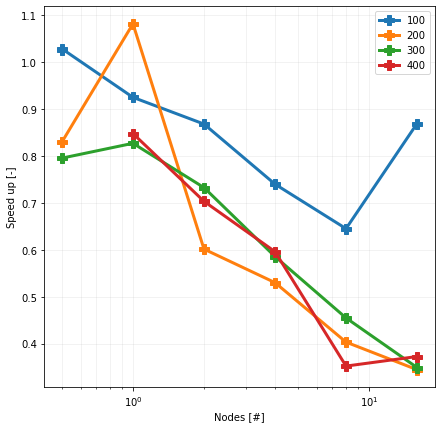

In [12]:

import pandas as pd
columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                        len(columns),
                        figsize=(7 * len(columns), 7),
                        sharex=False,
                        sharey=False,
                        gridspec_kw={'wspace': 0.5},
                        subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")

axes = [axes]
dfs = {}

for revision, marker, linestyle, cpu, case  in [("f66ef73d","P","-", 64, "simple"), ("14aed08a","x", ":", 64, "simple")]:
    path = "../../results/{}/lidDrivenCavity/".format(revision)
    df_tmp = import_results(
        path=path,
        case=case,        
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka"
        },
        transform_resolution=False
        )["raw"]
    df_tmp["revision"] = revision
    df_tmp = df_tmp.set_index("revision", append=True)
    dfs[revision] = df_tmp

    
df_c = pd.concat([dfs["f66ef73d"], dfs["14aed08a"]])
df = df_c.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)


df_gko = idx_query(df, [
        ("executor_p", "CUDA"),
        ("resolution", 500, False),
    ]).sort_index()

df_gko = calc_nodes(df_gko, "executor_p", [("CUDA", 4)])


data_s_gko = compute_speedup(df_gko,
        [("revision", "f66ef73d"),
        ],
        drop_indices=["node", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks", "mpiRank_of"],
        )

data_gko = idx_query(data_s_gko, [
        ("revision", "14aed08a"),
        ("resolution", 500, False),
    ]).sort_index()


for data, marker, linestyle  in [(data_gko,"P","-")]:
    line_plot(data["linear_solve_p"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        "linestyle": lambda x: linestyle,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        #ax.set_yscale('log')
        ax.set_xscale('log')


plt.savefig(path + case + "/device_aware_mpi.png", bbox_inches='tight')

../../results/1d7dd7a2/lidDrivenCavity/simple_1d/Logs
parse_log_strings could not convert string to float: '5.47724e-'
parse_log_strings could not convert string to float: '5.91921e'
parse_log_strings could not convert string to float: '3.1439e-'
parse_log_strings could not convert string to float: '-2.24777e-'
parse_log_strings could not convert string to float: '6.50169e-'
popping 93271aa8d5226ddc33d2d12044486cb9
popping 3a2c5b207fb62e094699bfd78e199464
popping c51ec21c999071df9f35847d50f556ed
popping 60ca08a9ee8fe3ddf4c81984d52f9bd6
popping 554fcd19d2f18da11a9e7842fa4a08b2


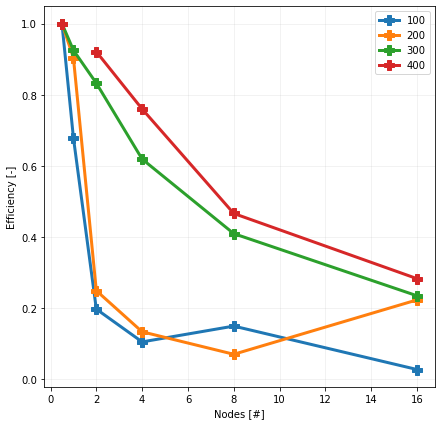

In [29]:
revision = "1d7dd7a2"
#revision_prev = "0e258ede"
case = "simple_1d"
path = "../../results/{}/lidDrivenCavity/".format(revision)

df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Efficiency [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
            ("resolution", 500, False),
            #("resolution", 400, False),
           # ("resolution", b)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df["nodes"] = df.index.get_level_values('mpi_ranks')
df["gpus"] = df.index.get_level_values("mpiRank_gko")

df = calc_nodes(df, "executor_p", [("DefaultOF", 76),("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 0.5),
         ("executor_p", "CUDA")
        ],
        drop_indices=["node", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data["efficiency_linear_solve_p_per_iter"] = of_data["linear_solve_p_per_iter"]*of_data["gpus"]

#of_data = idx_query(of_data, [
#        ("executor_p", "CUDA"),    
#    ]).sort_index()

              
line_plot(of_data["efficiency_linear_solve_p_per_iter"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")

plt.savefig(path + "/efficiency_solve_p_per_iter_multi_gpu_vs_single_node_CUDA.png", bbox_inches='tight')

../../results/1d7dd7a2/lidDrivenCavity/simple_1d/Logs
parse_log_strings could not convert string to float: '5.47724e-'
parse_log_strings could not convert string to float: '5.91921e'
parse_log_strings could not convert string to float: '3.1439e-'
parse_log_strings could not convert string to float: '-2.24777e-'
parse_log_strings could not convert string to float: '6.50169e-'
popping 93271aa8d5226ddc33d2d12044486cb9
popping 3a2c5b207fb62e094699bfd78e199464
popping c51ec21c999071df9f35847d50f556ed
popping 60ca08a9ee8fe3ddf4c81984d52f9bd6
popping 554fcd19d2f18da11a9e7842fa4a08b2
../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


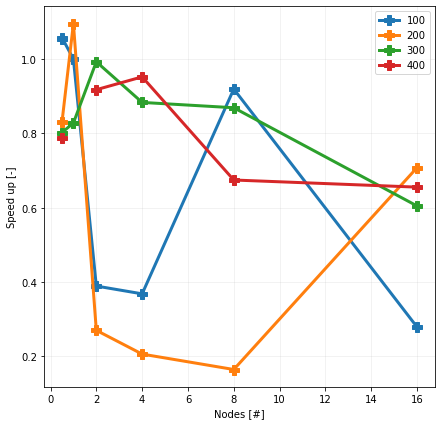

In [91]:
dfs = {}

fig, axes = plt.subplots(1,
                        len(columns),
                        figsize=(7 * len(columns), 7),
                        sharex=False,
                        sharey=False,
                        gridspec_kw={'wspace': 0.5},
                        subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")
axes = [axes]


for revision, marker, linestyle, cpu, case  in [
    ("1d7dd7a2","P", "-", 64, "simple_1d"), 
    ("f66ef73d","x", ":", 64, "simple")]:
    path = "../../results/{}/lidDrivenCavity/".format(revision)
    df_tmp = import_results(
        path=path,
        case=case,        
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka"
        },
        transform_resolution=False
        )["raw"]
    df_tmp["base"] = cpu
    #df_tmp = df_tmp.set_index("base", append=True)
    df_tmp["method"] = case
    df_tmp["revision"] = revision
    #df_tmp = df_tmp.set_index("revision", append=True)
    #df_tmp = df_tmp.set_index("method", append=True)
    dfs[revision] = df_tmp
    
df_c = pd.concat([dfs["1d7dd7a2"], dfs["f66ef73d"]])
df = df_c.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df=df.set_index("revision", append=True)
df=df.set_index("method", append=True)
df=df.set_index("base", append=True)

df_gko = idx_query(df, [
        ("executor_p", "CUDA"),
        ("resolution", 500, False),
    ]).sort_index()

df_gko = calc_nodes(df_gko, "executor_p", [("CUDA", 4)])


data_s_gko = compute_speedup(df_gko,
        [("method", "simple"),
        ],
        drop_indices=["node", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks", "base", "revision"],
        )

data_gko = idx_query(data_s_gko, [
        ("method", "simple_1d"),
        ("resolution", 500, False),
    ]).sort_index()

for data, marker, linestyle  in [(data_gko,"P","-")]:
    line_plot(data["linear_solve_p"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        "linestyle": lambda x: linestyle,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })
    

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')


#plt.savefig(path + case + "/speed_up_dd.png", bbox_inches='tight')

../../results/1d7dd7a2/lidDrivenCavity/simple_1d/Logs
parse_log_strings could not convert string to float: '5.47724e-'
parse_log_strings could not convert string to float: '5.91921e'
parse_log_strings could not convert string to float: '3.1439e-'
parse_log_strings could not convert string to float: '-2.24777e-'
parse_log_strings could not convert string to float: '6.50169e-'
popping 93271aa8d5226ddc33d2d12044486cb9
popping 3a2c5b207fb62e094699bfd78e199464
popping c51ec21c999071df9f35847d50f556ed
popping 60ca08a9ee8fe3ddf4c81984d52f9bd6
popping 554fcd19d2f18da11a9e7842fa4a08b2
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' cod

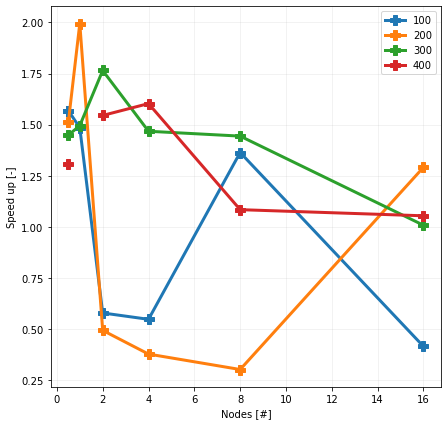

In [95]:
dfs = {}

fig, axes = plt.subplots(1,
                        len(columns),
                        figsize=(7 * len(columns), 7),
                        sharex=False,
                        sharey=False,
                        gridspec_kw={'wspace': 0.5},
                        subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")
axes = [axes]


for revision, marker, linestyle, cpu, case  in [
    ("1d7dd7a2","P", "-", 64, "simple_1d"), 
    ("f66ef73d","x", ":", 64, "simple")]:
    path = "../../results/{}/lidDrivenCavity/".format(revision)
    df_tmp = import_results(
        path=path,
        case=case,        
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka"
        },
        transform_resolution=False
        )["raw"]
    df_tmp["base"] = cpu
    #df_tmp = df_tmp.set_index("base", append=True)
    df_tmp["method"] = case
    df_tmp["revision"] = revision
    #df_tmp = df_tmp.set_index("revision", append=True)
    #df_tmp = df_tmp.set_index("method", append=True)
    dfs[revision] = df_tmp
    
df_c = pd.concat([dfs["1d7dd7a2"], dfs["f66ef73d"]])
df = df_c.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df=df.set_index("revision", append=True)
df=df.set_index("method", append=True)
df=df.set_index("base", append=True)

df_gko = idx_query(df, [
        ("executor_p", "CUDA"),
        ("resolution", 500, False),
    ]).sort_index()

df_gko = calc_nodes(df_gko, "executor_p", [("CUDA", 4)])


data_s_gko = compute_speedup(df_gko,
        [("method", "simple"),
        ],
        drop_indices=["node", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks", "base", "revision"],
        )

data_gko = idx_query(data_s_gko, [
        ("method", "simple_1d"),
        ("resolution", 500, False),
    ]).sort_index()

for data, marker, linestyle  in [(data_gko,"P","-")]:
    line_plot(data["linear_solve_p_per_iter"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        "linestyle": lambda x: linestyle,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })
    

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')


#plt.savefig(path + case + "/speed_up_dd.png", bbox_inches='tight')

../../results/f66ef73d/lidDrivenCavity/simple/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
../../results/1d7dd7a2/lidDrivenCavity/simple_1d/Logs
parse_log_strings could not convert string to float: '5.47724e-'
parse_log_strings could not convert string to float: '5.91921e'
parse_log_strings could not convert string to float: '3.1439e-'
parse_log_strings could not convert string to float: '-2.24777e-'
parse_log_strings could not convert string to float: '6.50169e-'
popping 93271aa8d5226ddc33d2d12044486cb9
popping 3a2c5b207fb62e094699bfd78e199464
popping c51ec21c999071df9f35847d50f556ed
popping 60ca08a9ee8fe3ddf4c81984d52f9bd6
popping 554fcd19d2f18da11a9e7842fa4a08b2
'utf-8' cod

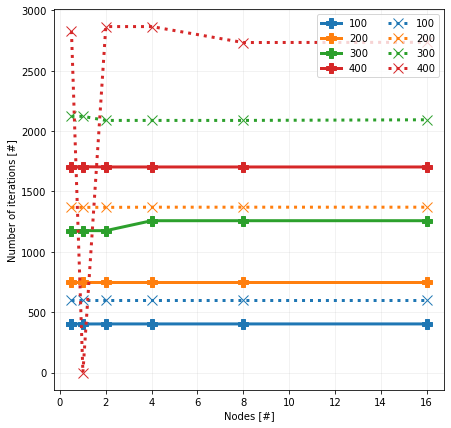

In [94]:
columns = ["linear_solve_p"]

fig, axes = plt.subplots(1,
                        len(columns),
                        figsize=(7 * len(columns), 7),
                        sharex=False,
                        sharey=False,
                        gridspec_kw={'wspace': 0.5},
                        subplot_kw={'frameon': True})
axes.set_ylabel("Number of iterations [#]")

axes = [axes]

for revision, marker, linestyle, cpu, case  in [("f66ef73d","P","-", 64, "simple"), ("1d7dd7a2","x", ":", 64, "simple_1d")]:
    path = "../../results/{}/lidDrivenCavity/".format(revision)
    df = import_results(
        path=path,
        case=case,        
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka"
        },
        transform_resolution=False
        )["raw"]


    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True)
            ])

    df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
    df = calc_nodes(df, "executor_p", [("DefaultOF", cpu), ("CUDA",4)])

    data = idx_query(df, [
            ("executor_p", "CUDA"),
            ("nodes", 64, False),
            ("resolution", 500, False),
            ("nodes", 32, False),
        ]).sort_index()

    line_plot(data["number_iterations_p"], 
            x="nodes", 
            columns=columns, 
            facet="resolution",
            #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
            fig=fig,
            axes=axes,
            facet_is_legend=True,
            properties={
            "linestyle": lambda x: linestyle,
            "marker": lambda x: marker,
            "title": lambda x: ["Linear Solve P"][x]
        })

for ax in axes:
    ax.grid(True, axis='x', which="both", alpha=0.2)
    ax.grid(True, axis='y', which="both", alpha=0.2)
    ax.grid(True, axis="y", which="minor", alpha=0.2)
    ax.set_xlabel("Nodes [#]")
    
plt.legend(ncol=2)#, loc="top center")
print(path, case)
plt.savefig(path + case +  "/number_iterations_scotch_vs_simple_dd.png", bbox_inches='tight')